# Bitcoin Price Movement Prediction with CNN-LSTM

## 1-Introduction

- This notebook demonstrates the development of a time-series classification model to predict short-term price direction (up or down) for the BTC/USDT cryptocurrency pair. 
- Using historical OHLCV data from Binance, we engineered technical indicators as features, preprocessed the data, and trained a hybrid CNN-LSTM deep learning model. 
- The goal is to classify whether the closing price will increase over a 6-hour forecast horizon based on 30-minute interval candles. We evaluate the model using accuracy, F1-score, and confusion matrix metrics to understand its performance on validation and test datasets.

## 2-Data Acquisition

In [ ]:
# Exchange API client for fetching crypto market data
import ccxt

# Data manipulation and analysis
import pandas as pd

# Time management utilities
import time
from datetime import datetime, timedelta

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical correlation between binary and continuous variables
from scipy.stats import pointbiserialr

# Numerical computing core library
import numpy as np

# Data splitting and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Deep learning model construction
from keras.models import Sequential

# Neural network layers for sequential and convolutional modeling
from keras.layers import Conv1D, LSTM, Dense, Dropout

# Optimizer for training the model
from keras.optimizers import Adam

# Metrics to evaluate classification performance
from keras.metrics import BinaryAccuracy, AUC, Precision, Recall

# Generate batches of temporal sequences for time series modeling
from keras.preprocessing.sequence import TimeseriesGenerator

# Callbacks to improve training process (early stopping, learning rate reduction)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Backend engine for Keras and overall deep learning framework
import tensorflow as tf

# Custom plotting utility for visualizing learning progress
from tools import PlotLearning

In [330]:
exchange = ccxt.binance()

# Get current time in milliseconds since epoch
now = exchange.milliseconds()

# Calculate the datetime for exactly one year ago from now (365 days)
one_year_ago = datetime.utcnow() - timedelta(days=365)

# Convert this datetime to ISO8601 string format, 
# then parse it to a timestamp that ccxt understands (in milliseconds)
since = exchange.parse8601(one_year_ago.strftime('%Y-%m-%dT%H:%M:%SZ'))

In [331]:
all_ohlcv = []
limit = 500  # Maximum number of bars (candles) to fetch per API call (exchange limitation)
frame = 30  # Timeframe in minutes for each candle

# Loop to fetch historical OHLCV data in batches until we reach current time
while since < now:
    # Fetch OHLCV data for BTC/USDT with given timeframe, starting from 'since' timestamp
    ohlcv = exchange.fetch_ohlcv('BTC/USDT', timeframe=f'{frame}m', since=since, limit=limit)
    
    # If no more data is returned, break the loop
    if not ohlcv:
        break
    
    # Append fetched data to the main list
    all_ohlcv += ohlcv
    
    # Update 'since' to just after the last timestamp received to avoid overlap
    since = ohlcv[-1][0] + 1
    
    # Pause briefly to avoid hitting API rate limits
    time.sleep(0.5)

In [293]:
df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.tail()

,timestamp,open,high,low,close,volume,datetime
17515,1748433600000,108870.39,109050.00,108840.01,109013.34,160.16349,2025-05-28 12:00:00
17516,1748435400000,109013.34,109053.39,108784.27,108891.94,213.50740,2025-05-28 12:30:00
17517,1748437200000,108891.94,108903.99,108640.00,108722.45,268.48111,2025-05-28 13:00:00
17518,1748439000000,108722.45,108985.05,108010.00,108068.45,836.05027,2025-05-28 13:30:00
17519,1748440800000,108068.45,108253.03,107982.40,108144.00,298.65326,2025-05-28 14:00:00


- The raw OHLCV data is converted into a structured DataFrame for easier analysis. Timestamps are transformed into readable datetime format to enable time-based operations. The last few rows are shown to verify the data.

## 3-Data Preparation and Feature Engineering

In [ ]:
hour_window=6
forecast_horizon = int(hour_window*60/frame)  # 24 candle = 6 hour

df['Target'] = (df['close'].shift(-forecast_horizon) > df['close']).astype(int)

df = df[:-forecast_horizon]

- A binary target is created to indicate whether the price will rise in the next 6 hours. The last 24 rows are removed since they lack future data to compute the target.

In [332]:
def add_technical_indicators(df,
                             sma_hours=[5, 10, 14, 30],
                             ema_hours=[5, 10, 14, 30],
                             momentum_hours=[5, 10, 14],
                             stochastic_hours=14,
                             stochastic_smooth=3,
                             macd_fast_hours=12,
                             macd_slow_hours=26,
                             macd_signal_hours=9,
                             rsi_hours=[14, 28],
                             williams_hours=[14, 28],
                             cci_hours=[14]):
    """
    Calculates a set of technical indicators using time-based periods.
    Converts hours into the equivalent number of 30-minute bars and applies rolling calculations.
    """

    # Converts a period in hours into the equivalent number of 30-minute candles (bars)
    def to_bars(hours):
        return int(hours * 60 / frame)

    # Exponential Moving Average (EMA) using pandas' ewm function
    def EMA(series, span):
        return series.ewm(span=span, adjust=False).mean()

    # Simple Moving Average (SMA)
    for h in sma_hours:
        p = to_bars(h)
        df[f'SMA_{h}h'] = df['close'].rolling(window=p).mean()

    # Exponential Moving Average (EMA)
    for h in ema_hours:
        p = to_bars(h)
        df[f'EMA_{h}h'] = EMA(df['close'], p)

    # Momentum: Difference between current close and close from N periods ago
    for h in momentum_hours:
        p = to_bars(h)
        df[f'Momentum_{h}h'] = df['close'] - df['close'].shift(p)

    # Stochastic Oscillator: Measures close relative to the high-low range over a period
    p = to_bars(stochastic_hours)
    low_min = df['low'].rolling(window=p).min()
    high_max = df['high'].rolling(window=p).max()
    df['Stoch_%K'] = 100 * ((df['close'] - low_min) / (high_max - low_min))
    df['Stoch_%D'] = df['Stoch_%K'].rolling(window=stochastic_smooth).mean()

    # MACD: Difference between fast and slow EMAs, with signal line
    fast_p = to_bars(macd_fast_hours)
    slow_p = to_bars(macd_slow_hours)
    signal_p = to_bars(macd_signal_hours)
    ema_fast = EMA(df['close'], fast_p)
    ema_slow = EMA(df['close'], slow_p)
    df['MACD_line'] = ema_fast - ema_slow
    df['MACD_signal'] = EMA(df['MACD_line'], signal_p)

    # RSI (Relative Strength Index): Measures recent gains vs. losses
    delta = df['close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    for h in rsi_hours:
        p = to_bars(h)
        ma_up = up.rolling(window=p).mean()
        ma_down = down.rolling(window=p).mean()
        rs = ma_up / ma_down
        df[f'RSI_{h}h'] = 100 - (100 / (1 + rs))

    # Williams %R: Measures overbought/oversold levels
    for h in williams_hours:
        p = to_bars(h)
        high_p = df['high'].rolling(window=p).max()
        low_p = df['low'].rolling(window=p).min()
        df[f'Williams_%R_{h}h'] = -100 * ((high_p - df['close']) / (high_p - low_p))

    # Accumulation/Distribution Index (ADI): Volume-based indicator of trend strength
    mfm = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low']).replace(0, np.nan)
    mfm = mfm.fillna(0)
    mfv = mfm * df['volume']
    df['ADI'] = mfv.cumsum()

    # Commodity Channel Index (CCI): Identifies cyclical trends around a moving average
    for h in cci_hours:
        p = to_bars(h)
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        sma_tp = typical_price.rolling(window=p).mean()
        mean_dev = typical_price.rolling(window=p).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
        df[f'CCI_{h}h'] = (typical_price - sma_tp) / (0.015 * mean_dev)

    return df

- This function adds a wide range of technical indicators to the dataset to enrich the feature set for model training. It converts indicator parameters from hours to 30-minute candle units and computes moving averages, momentum, oscillators, and volume-based signals. These indicators help capture market trends, momentum shifts, and overbought/oversold conditions, making the data more informative for predictive modeling.

In [333]:
df_indicator = add_technical_indicators(df)

- Technical indicators are calculated and added to the DataFrame, enhancing the dataset with features that capture market patterns and trends for improved analysis and modeling.

In [334]:
df_indicator.isna().sum()

timestamp           0
open                0
high                0
low                 0
close               0
volume              0
datetime            0
Target              0
SMA_5h              9
SMA_10h            19
SMA_14h            27
SMA_30h            59
EMA_5h              0
EMA_10h             0
EMA_14h             0
EMA_30h             0
Momentum_5h        10
Momentum_10h       20
Momentum_14h       28
Stoch_%K           27
Stoch_%D           29
MACD_line           0
MACD_signal         0
RSI_14h            28
RSI_28h            56
Williams_%R_14h    27
Williams_%R_28h    55
ADI                 0
CCI_14h            27
dtype: int64

- Check for missing values in each column to identify any gaps in the data that may need cleaning or imputation before modeling. There are some so we need to drop them out.

In [ ]:
df_indicator = df_indicator.dropna().reset_index(drop=True)

- Remove all rows with missing values to ensure a clean dataset, then reset the index for consistent row numbering.

## 4-Exploratory Data Analysis (EDA)

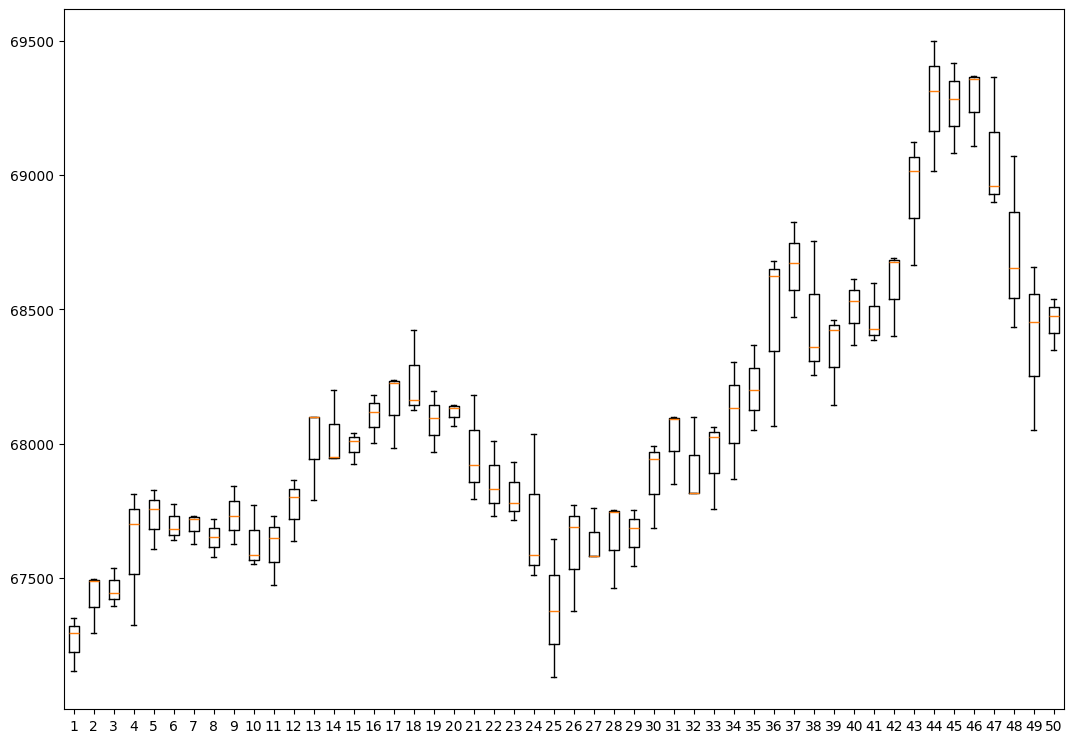

In [ ]:
data = np.array([df_indicator['low'].iloc[:50], df_indicator['close'].iloc[:50], df_indicator['high'].iloc[:50]])

fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

- This code visualizes the distribution and potential outliers of the first 50 low, close, and high prices using boxplots, helping to understand the spread and variability in key price features.

In [298]:
df_indicator=df_indicator.drop(["timestamp","datetime"],axis=1)

- Remove the original timestamp columns since datetime information is no longer needed for modeling, keeping only relevant numeric features.

col: open  corr: -0.01518845762293989  pval: 0.044825724148973595
col: high  corr: -0.01517438558323072  pval: 0.045024323858632614
col: low  corr: -0.01538945108710633  pval: 0.04206878217094995
col: close  corr: -0.015590438140136786  pval: 0.039456769851295585
col: volume  corr: 0.005735500447707797  pval: 0.44870188624124546
col: SMA_5h  corr: -0.014615887860675667  pval: 0.05352689665275475
col: SMA_10h  corr: -0.014049515853460426  pval: 0.06347854954874174
col: SMA_14h  corr: -0.013566126001397557  pval: 0.07313826564971089
col: SMA_30h  corr: -0.010731690832022737  pval: 0.15632559211057667
col: EMA_5h  corr: -0.014698763378957522  pval: 0.0521862726071702
col: EMA_10h  corr: -0.013986328991180418  pval: 0.06467797850055007
col: EMA_14h  corr: -0.013429668247063561  pval: 0.07607300867698959
col: EMA_30h  corr: -0.011920782415396451  pval: 0.11534536841878242
col: Momentum_5h  corr: -0.026891525105232475  pval: 0.0003814224353849027
col: Momentum_10h  corr: -0.03339888005328360

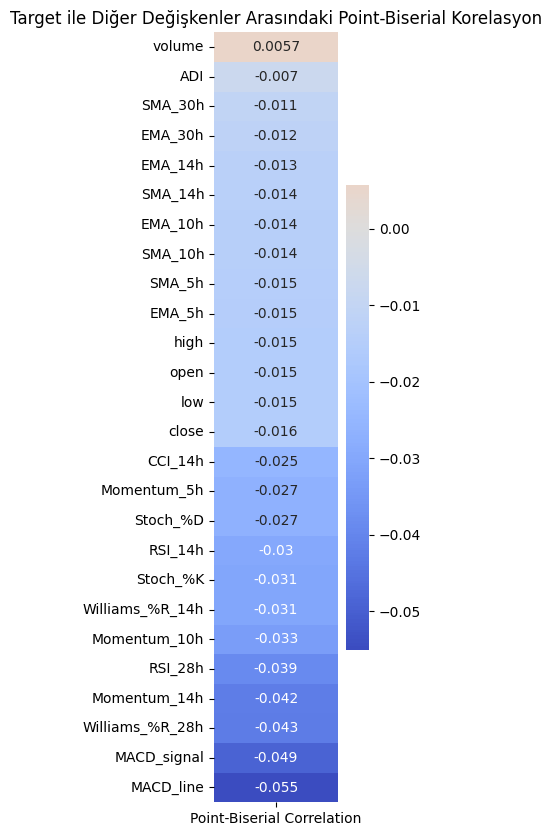

In [ ]:
binary_var = df_indicator["Target"]  # Binary değişken

# Korelasyonları saklamak için dict
correlations = {}

for col in df_indicator.columns:
    if col != "Target":  # Target ile kendi arasında korelasyon anlamlı değil, atla
        corr, pval = pointbiserialr(binary_var, df_indicator[col])
        print("col:",col," corr:",corr," pval:",pval)
        correlations[col] = corr

# DataFrame'e çevir
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Point-Biserial Correlation'])

# Heatmap için matrise dönüştür
corr_matrix = corr_df.T
corr_df_sorted = corr_df.sort_values(by='Point-Biserial Correlation', ascending=False)

plt.figure(figsize=(2, 10))
sns.heatmap(corr_df_sorted, annot=True, cmap='coolwarm', center=0)
plt.title('Target ile Diğer Değişkenler Arasındaki Point-Biserial Korelasyon')
plt.show()


- This code calculates the point-biserial correlation between the binary target and each feature to assess their linear relationship. It prints correlation coefficients and p-values, then visualizes these correlations sorted by strength in a heatmap.

- The results show generally very weak correlations (close to zero), mostly negative, indicating slight inverse relationships. Despite this, many correlations are statistically significant (very low p-values), particularly for momentum and MACD indicators, which exhibit the strongest negative correlations (around -0.03 to -0.055). This suggests these technical indicators carry more predictive value for price direction. On the other hand, features like volume and ADI show near-zero, non-significant correlations, implying little direct impact on the target.

- Overall, the weak correlations highlight that the target’s behavior is complex and may require nonlinear models to uncover meaningful patterns beyond simple linear associations.

## 5-Data Preprocessing

In [310]:
features = [
    "MACD_line",
    "MACD_signal",
    "RSI_28h",
    "Williams_%R_28h",
    "Momentum_14h",
    "Momentum_10h",
    "Momentum_5h",
    "Stoch_%K",
    "Stoch_%D",
    "Williams_%R_14h",
    "RSI_14h",
    "CCI_14h"
]


- Selected features focus on momentum, trend, and oscillator indicators that showed stronger correlations with the target, aiming to improve model performance by using the most relevant technical signals.

In [311]:
X = np.array(df_indicator[features])
y = np.array(df_indicator['Target'])

- Prepare the input features (`X`) and target labels (`y`) as NumPy arrays for machine learning, using the selected technical indicators and the binary price movement target.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Scale the feature data to have zero mean and unit variance, improving model training stability and performance.

In [335]:
def print_target_distribution(y, dataset_name="Dataset"):
    """
    Prints the class distribution of a target variable.
    
    Args:
        y (array-like): Target vector containing class labels (e.g., 0 and 1).
        dataset_name (str): Name of the dataset (e.g., "Train", "Test").
    """
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{dataset_name} Target Distribution:")
    total = len(y)
    for label, count in zip(unique, counts):
        print(f"  Class {label}: {count} samples ({count/total*100:.2f}%)")


- This function prints the distribution of classes in a target array, showing how many samples belong to each class and their percentage, helping to assess class balance in datasets.

In [314]:
split_train = int(len(X_scaled) * 0.7)
split_val = int(len(X_scaled) * 0.85)

X_train, y_train = X_scaled[:split_train], y[:split_train]
X_val, y_val = X_scaled[split_train:split_val], y[split_train:split_val]
X_test, y_test = X_scaled[split_val:], y[split_val:]

print_target_distribution(y_train, "Train")
print_target_distribution(y_val, "Validation")
print_target_distribution(y_test, "Test")


Train Target Distribution:
  Class 0: 5853 samples (47.92%)
  Class 1: 6361 samples (52.08%)

Validation Target Distribution:
  Class 0: 1302 samples (49.75%)
  Class 1: 1315 samples (50.25%)

Test Target Distribution:
  Class 0: 1198 samples (45.76%)
  Class 1: 1420 samples (54.24%)


- The data is split into training, validation, and test sets with proportions of 70%, 15%, and 15% respectively, ensuring the model can be trained, tuned, and evaluated properly. 
- The target class distributions in all splits are well balanced—each class holds close to 50% of the samples—reducing the risk of bias and helping the model learn patterns fairly across both classes for better generalization.

## 6-Sequence Data Preparation

In [ ]:
sequence_length = int(hour_window*60/frame)  # 6 hours if 15min intervals (24 x 15min)
batch_size = 32

train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=batch_size)

- Create time series data generators that produce batches of sequential samples with a 6-hour window, enabling models to learn temporal patterns while efficiently handling data during training, validation, and testing.

## 7-Model Building

In [ ]:
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(LSTM(128, activation='tanh',return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
    ]
)
    model.summary()
    return model

- Builds a hybrid CNN-LSTM model to capture both local patterns (via Conv1D) and long-term dependencies (via LSTM) in sequential data. It uses dropout for regularization and outputs a binary prediction with sigmoid activation. 
- The model is compiled with binary cross-entropy loss and evaluation metrics for classification performance.

In [320]:
model = build_cnn_lstm_model(input_shape=(sequence_length, len(features)))

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_57 (Conv1D)          (None, 10, 32)            1184      
                                                                 
 conv1d_58 (Conv1D)          (None, 8, 16)             1552      
                                                                 
 lstm_36 (LSTM)              (None, 64)                20736     
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23,537
Trainable params: 23,537
Non-trainable params: 0
_________________________________________________________________


- Initialize the CNN-LSTM model with the input shape matching the sequence length and number of selected features, preparing it for training on the time series data.

## 8-Model Training

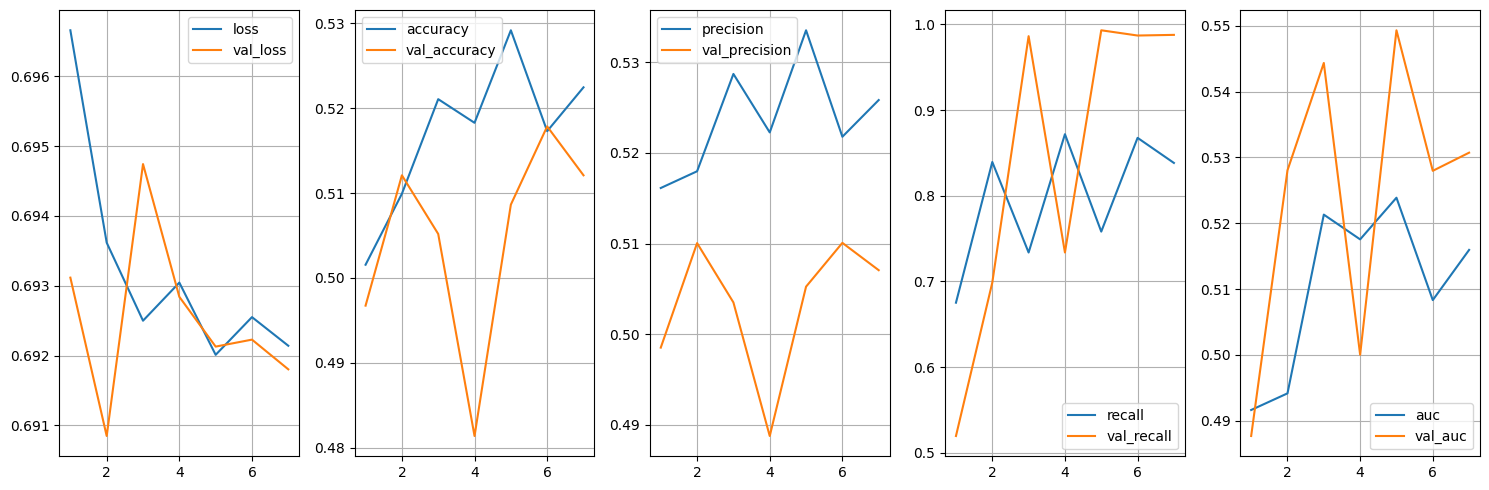

382/382 [==============================] - 6s 16ms/step - loss: 0.6921 - accuracy: 0.5225 - precision: 0.5258 - recall: 0.8383 - auc: 0.5159 - val_loss: 0.6918 - val_accuracy: 0.5121 - val_precision: 0.5071 - val_recall: 0.9878 - val_auc: 0.5307 - lr: 0.0010


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[early_stop,PlotLearning(),ReduceLROnPlateau()],
        verbose=True
    )

- Set up callbacks to stop training early if validation loss stops improving and to reduce learning rate when progress plateaus, then train the model on the GPU using the time series generators, tracking learning progress with a custom plot.

## 9-Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

y_val_pred_prob = model.predict(val_generator)
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()

y_val_true = y_val[sequence_length:]

print(f"Validation Accuracy: {accuracy_score(y_val_true, y_val_pred):.4f}")
print(f"Validation F1 Score: {f1_score(y_val_true, y_val_pred):.4f}")

plt.show()

82/82 [==============================] - 1s 4ms/step
Validation Accuracy: 0.5121
Validation F1 Score: 0.5896


- The validation accuracy around 51% indicates the model’s overall correctness is just slightly better than random guessing, reflecting a challenging prediction task. 
- However, the F1 score of about 0.59 shows the model balances precision and recall better, suggesting it is somewhat effective at detecting positive cases despite low accuracy. 
- Together, these metrics imply the model learns meaningful signals but requires further tuning or additional data/features to improve its classification reliability.

In [323]:
y_test_pred_prob = model.predict(test_generator)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()
y_test_true = y_test[sequence_length:]

print(f"Test Accuracy: {accuracy_score(y_test_true, y_test_pred):.4f}")
print(f"Test F1 Score: {f1_score(y_test_true, y_test_pred):.4f}")

82/82 [==============================] - 0s 5ms/step
Test Accuracy: 0.5215
Test F1 Score: 0.5716


- Test results show a slight improvement with accuracy around 52%, still close to random, indicating the model struggles with overall correct classification. 
- The F1 score of about 0.57 confirms moderate ability to balance precision and recall, similar to validation performance. This consistency suggests the model generalizes its partial predictive power but still needs enhancements for stronger, more reliable predictions.

Confusion Matrix:
[[527 668]
 [579 832]]


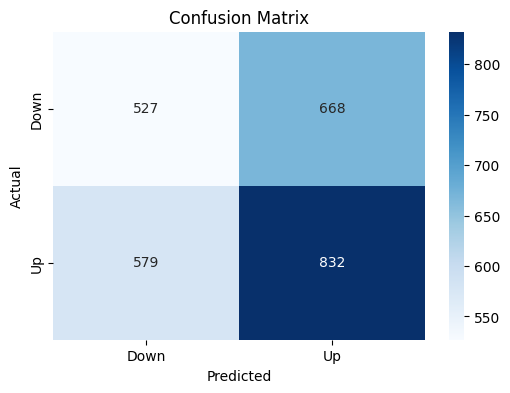

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix reveals the model's prediction details on the test set:

* True Negatives (Down correctly predicted): 527
* False Positives (Down predicted as Up): 668
* False Negatives (Up predicted as Down): 579
* True Positives (Up correctly predicted): 832

This shows the model predicts the "Up" class more often but also misclassifies many samples, especially confusing "Down" samples as "Up." The imbalance between false positives and false negatives suggests the model tends to overpredict upward movement, which aligns with the moderate F1 but low accuracy. Improvement could focus on reducing false positives to enhance overall reliability.

In [ ]:
cr = classification_report(y_test_true, y_test_pred)
print("Classification Report:")
print(cr)

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.44      0.46      1195
           1       0.55      0.59      0.57      1411

    accuracy                           0.52      2606
   macro avg       0.52      0.52      0.51      2606
weighted avg       0.52      0.52      0.52      2606



This classification report shows:

* **Class 0 (Down):**

  * Precision: 48% (when the model predicts Down, it's correct 48% of the time)
  * Recall: 44% (it detects 44% of actual Down cases)
  * F1-score: 46% (balance of precision and recall)

* **Class 1 (Up):**

  * Precision: 55%
  * Recall: 59%
  * F1-score: 57%

* **Overall accuracy:** 52% — barely better than random guessing.

* Both classes have similar performance, but "Up" class detection is notably better.

This indicates the model can somewhat identify upward trends but struggles with downward trends, and the overall predictive power is modest. Improvements might include more data, feature engineering, model tuning, or addressing class imbalance.


## 10-Summary and Conclusion

The CNN-LSTM model showed modest predictive ability, with around 52% accuracy and F1 scores slightly above random chance. The model performed better in detecting upward price movements than downward ones. This highlights the challenge of forecasting cryptocurrency price direction with limited features and data. Future improvements could include enhanced feature engineering, longer historical data, tuning model architecture, and incorporating additional data sources. Despite the modest results, this approach provides a solid foundation for time-series classification in financial markets.